# 序列建模：循环神经网络

时间序列和文本分析都涉及到序列的分析：在时间序列中，指的是$\left\{x_t, t=1,2,...,T\right\}$，其中$x_t$可以是$k$维向量，而在文本分析中，如果我们把每个词都看成是一个向量，那么一个句子、文章就可以看成是词向量的序列。

就像在时间序列中的分析一样，序列建模的关键点在于时间上的相依性：在时间维度上，不同时间点的$x_t$显然应该是相关的。特别是对于一些长记忆的模型，可能间隔时间比较长的过去也会对现在造成影响。

而**循环神经网络**（**recurrent neural networks**，**RNN**）通过引入神经元之间的“循环”（cycles），来对序列的不同期之间相依性进行建模。

在循环神经网络的建模中，有一个“隐藏的状态”（hidden state），包含了将观察到的时间序列进行运算并体现最终标签的信息。RNN的建模方法与状态空间模型、隐马尔科夫链等有非常类似的地方，但是不同于这些模型的地方是，在RNN中，并没有对隐藏状态的更新函数做任何假设。

如果我们记$h_t$为隐藏的状态，那么循环神经网络的结构可以写为如下的形式：$$h_t=f\left(h_{t-1},x_t\right)$$其中$x_t$为当期的可观测变量，而$h_{t-1}$为上一期的隐藏状态。

以上过程可以使用如下图表示：

![](pic/RNN.gv.png "RNN")

其中上图为RNN表示的一般简单表示，而下面的图是上面的图的展开形式。在上面的图中，我们使用了一个$h$指向$h$本身的箭头，说明隐藏状态$h$是自我更新的。

经过迭代，第$t$期的状态可以写为过去所有可观测变量的函数：$$h_t=g\left(x_1,x_2,...,x_t\right)=f\left(h_{t-1},x_t\right)=f\left(f\left(h_{t-2},x_{t-1}\right),x_t\right)=\cdots $$从而$f$可以看作是一个将过去的信息整合的过程，而由于$f$函数随时间的不变性，我们就可以根据当期的$h_t$预测下一期的$h_{t+1}$，进而对标签进行预测。所以这里的关键点在于$f$：$f$在不同期的函数形式相同，从而在不同期之间共享参数，可以看做具有马尔科夫性质。

在PyTorch中，可以使用torch.nn.RNN()来创建RNN层，其函数形式为：$$h_t=tanh\left(W_{ih}x_t+b_{ih}+W_{hh}h_{t-1}+b_{hh}\right)$$我们一般使用tanh激活函数，不过也可以使用ReLU激活函数。

下面我们使用一个简单的债券收益率预测展示RNN的用法。首先载入数据：

In [1]:
import pandas as pd
import numpy as np

IR = pd.read_csv("csv/bond_interest.csv")
IR

,Date,IB010007,IB010011,SH010107,SH010303,SH010504,SH010512,SH010609,SH010619,SH010706,...,IB200003,IB209901,IB209902,IB209903,IB209904,IB209905,IB209906,IB209907,IB209908,IB209909
0,2018-01-02,4.1168,3.8014,4.1168,4.2580,3.9000,3.7726,3.9000,3.8026,4.2265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,4.0911,3.7837,4.0911,4.2822,3.9052,3.7370,3.9122,3.7873,4.2339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-04,4.1428,3.8092,4.1428,4.3109,3.9137,3.7391,3.9216,3.8136,4.2414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-05,4.1080,3.7726,4.1080,4.2829,3.9103,3.7046,3.9174,3.7765,4.2314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-08,4.0987,3.7356,4.0987,4.2629,3.9036,3.6663,3.9086,3.7403,4.2214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,2020-02-27,2.0304,2.1411,2.0304,2.5027,2.6275,1.8926,2.7841,2.1709,3.1601,...,NaN,1.7054,1.8110,1.7243,1.7327,1.7477,1.8384,1.7489,1.7499,NaN
522,2020-02-28,2.0280,2.1188,2.0280,2.5090,2.5566,1.9142,2.7240,2.1443,3.1405,...,NaN,1.7111,1.8361,1.7267,1.7334,1.7556,1.8314,1.7681,1.7800,NaN
523,2020-03-02,2.0221,2.1136,2.0221,2.5213,2.5658,1.9103,2.7314,2.1395,3.1599,...,NaN,1.6720,1.8412,1.6854,1.7498,1.7190,1.8299,1.7418,1.7638,1.7819
524,2020-03-03,2.0536,2.1320,2.0536,2.5319,2.5607,1.9187,2.7390,2.1540,3.1682,...,NaN,1.6581,1.8349,1.6691,1.7323,1.7003,1.8301,1.7318,1.7601,1.7799


接下来，我们希望使用前29天的数据预测明天的收益率，所以我们要将数据整理为时间序列的格式，并产生滞后项：

In [2]:
IR_long = IR.iloc[:, 1:]
IR_long = IR_long.T.stack()
IR_long = pd.DataFrame({'r': IR_long})
IR_long['label'] = IR_long['r'].groupby(level=0).shift(-1)
lag_length = 29
for i in range(lag_length - 1):
    IR_long['r_' + str(i + 1)] = IR_long['r'].groupby(level=0).shift(i + 1)
IR_long = IR_long.dropna()
IR_long['random'] = np.random.random(IR_long.shape[0])
IR_long = IR_long.sort_values('random')
del IR_long['random']
Y = IR_long['label']
X = IR_long.drop(['label'], axis=1)
X = X.T
X['n'] = np.arange(X.shape[0])
X = X.sort_values('n', ascending=False)
del X['n']
X

,SZ101510,SH019510,SZ101727,IB080002,SZ101614,BC170018,SZ101808,SH019112,BC140005,BC180009,...,IB080013,SH019580,SZ101034,SH019603,IB100007,IB160023,SZ101034,SH019406,SH019806,SZ101716
,271,321,327,458,385,120,497,291,328,258,...,136,474,143,350,358,454,449,281,129,434
r_28,3.6907,3.7654,3.0504,2.8275,2.9866,3.6909,2.5050,3.7371,2.9545,2.9667,...,3.6241,3.2393,3.3610,2.9179,2.6573,3.1678,2.5716,2.5761,3.9707,2.3550
r_27,3.6957,3.7555,3.0499,2.8325,2.9928,3.6974,2.5093,3.7303,3.0079,3.0007,...,3.6043,3.2484,3.3611,2.9695,2.6417,3.1606,2.5556,2.5373,3.9769,2.3577
r_26,3.7158,3.7330,3.1128,2.8314,3.0114,3.6622,2.5350,3.7327,3.0323,3.0124,...,3.5617,3.2627,3.3157,2.9353,2.6266,3.1682,2.5521,2.5470,3.9819,2.3616
r_25,3.7158,3.7140,3.1464,2.8194,2.9995,3.6582,2.5256,3.7185,3.0752,3.0238,...,3.6068,3.2646,3.2749,2.9401,2.6278,3.1839,2.5488,2.5957,3.9744,2.3326
r_24,3.6908,3.7116,3.1962,2.8224,2.9960,3.6499,2.5128,3.7185,3.1265,3.0230,...,3.5767,3.2366,3.2486,2.9485,2.6736,3.1914,2.5707,2.5776,3.9745,2.3129
r_23,3.7158,3.7191,3.2219,2.8483,2.9544,3.6471,2.5112,3.7092,3.1558,3.0137,...,3.5618,3.2400,3.2162,2.9324,2.6486,3.1936,2.5547,2.5898,3.9945,2.3360
r_22,3.7333,3.7141,3.2378,2.8564,2.9367,3.6596,2.4541,3.7190,3.2197,2.9852,...,3.5816,3.2250,3.2015,2.9428,2.6566,3.1890,2.5691,2.5865,3.9782,2.3175
r_21,3.7308,3.6944,3.2845,2.8554,2.9291,3.6687,2.4435,3.7314,3.2025,2.9879,...,3.5817,3.2402,3.1957,2.9484,2.7121,3.1765,2.5699,2.5822,3.9558,2.2974
r_20,3.7408,3.7392,3.2747,2.8448,2.9585,3.6994,2.4419,3.7481,3.1727,3.0096,...,3.5542,3.2284,3.1836,2.9367,2.6452,3.1994,2.5597,2.6620,3.9407,2.2834


然后定义数据集和数据加载器：

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

Y_train = Y.iloc[:270000]
X_train = X.iloc[:, :270000]
Y_test = Y.iloc[270000:]
X_test = X.iloc[:, 270000:]


class IR_data(Dataset):

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[1]

    def __getitem__(self, i):
        x = torch.tensor(self.X.iloc[:, i])
        label = torch.tensor(self.Y.iloc[i])
        return x, label


batch_size = 500

train_data = IR_data(X_train, Y_train)
dl = DataLoader(train_data,
                shuffle=True,
                batch_size=batch_size,
                pin_memory=True,
                num_workers=10)


接下来定义RNN模型。我们可以使用nn.RNN来创建RNN层，创建该层时需要的参数有：

* input_size：输入的大小，也就是特征数量，在上面的例子中，我们并没有使用其他的时间序列帮助预测，仅仅是收益率的滞后，那么input_size=1；如果我们加入了其他时间序列共同预测，比如加入了SHIBOR等，那么input_size=2
* hidden_size：隐藏状态的数量
* num_layers：嵌套的RNN的层数，默认为1，即只有一个RNN，可以多个RNN套在一起使用（多个RNN串联起来）
* nonlinearity： relu或者tanh，用于拟合$f$函数的激活函数
* dropout：用于拟合$f$函数的网络的dropout概率，默认为0，即不做dropout

经过初始化之后，返回一个计算RNN的函数（比如起名为rnn），该函数需要的输入为：

* x：可观测的$x$，注意形状应该为（序列长度$T$×批大小$B$×input_size）
* h_0：隐藏状态矩阵，形状应该为（层数num_layers×批大小×hidden_size），一般初始化为0

所以在下面的定义中，我们还构造了一个初始化h矩阵的函数

该函数得到的输出也有两个：

* output：输出的状态，形状为（序列长度$T$×批大小$B$×hidden_size），即返回了每个时间$t$的隐藏状态
* h_n：$t=T$时的隐藏状态，形状为（层数num_layers×批大小$B$×hidden_size），即最终时刻不同层的RNN的隐藏状态

比如：

In [4]:
from torch import nn
import numpy as np
# 序列长度为5，每个batch有10个样本，1层（单个）RNN，隐藏状态数量为2个，变量个数为1
batch_len = 10
seq_len = 5
hidden_size = 2
rnn = nn.RNN(input_size=1, hidden_size=hidden_size)

hidden = torch.zeros(1, batch_len, hidden_size)
x = torch.tensor(np.random.random((seq_len, batch_len, 1))).float()

print("初始的隐藏状态：\n%s" % hidden)
print("数据：\n%s\n 形状：%s" % (x, x.shape))

out, hn = rnn(x, hidden)

print("output=\n%s" % out)
print("h_n=\n%s" % hn)
print("output[-1]=\n%s" % out[-1])

初始的隐藏状态：
tensor([[[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]])
数据：
tensor([[[0.7329],
         [0.0712],
         [0.2676],
         [0.6008],
         [0.5957],
         [0.0201],
         [0.1616],
         [0.6980],
         [0.5511],
         [0.3454]],

        [[0.2540],
         [0.6135],
         [0.2185],
         [0.7870],
         [0.5979],
         [0.1410],
         [0.1753],
         [0.9912],
         [0.2242],
         [0.8234]],

        [[0.9572],
         [0.4853],
         [0.3195],
         [0.1507],
         [0.1896],
         [0.2773],
         [0.2488],
         [0.3728],
         [0.3903],
         [0.5662]],

        [[0.6967],
         [0.3983],
         [0.5251],
         [0.5580],
         [0.4968],
         [0.0174],
         [0.6082],
         [0.2834],
         [0.0396],
         [0.8965]],

        [[0.2374],
        

可以看到，h_n返回的结果和output\[-1\]返回的结果一样，都是最后一期batch中每个样本的隐藏状态。

以上是只有一层RNN的情况，如果有两层RNN，那么返回的hn实际上包含了两层RNN最终时间的序列状态，而output\[-1\]则只包含了最后一层、最后一期的隐藏状态：

In [5]:
from torch import nn
import numpy as np
# 序列长度为5，每个batch有10个样本，1层（单个）RNN，隐藏状态数量为2个，变量个数为1
batch_len = 10
seq_len = 5
hidden_size = 2
rnn = nn.RNN(input_size=1, hidden_size=hidden_size, num_layers=2)

hidden = torch.zeros(2, batch_len, hidden_size)
x = torch.tensor(np.random.random((seq_len, batch_len, 1))).float()

print("初始的隐藏状态：\n%s" % hidden)
print("数据：\n%s\n 形状：%s" % (x, x.shape))

out, hn = rnn(x, hidden)

print("output=\n%s" % out)
print("h_n=\n%s" % hn)
print("output[-1]=\n%s" % out[-1])

初始的隐藏状态：
tensor([[[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]])
数据：
tensor([[[7.7206e-01],
         [5.9411e-01],
         [6.0247e-01],
         [8.5634e-02],
         [6.2373e-01],
         [2.4784e-01],
         [2.2806e-01],
         [1.3007e-02],
         [3.5345e-01],
         [3.5433e-02]],

        [[8.9365e-01],
         [7.2431e-02],
         [3.8674e-01],
         [4.2065e-01],
         [8.3363e-01],
         [8.1836e-01],
         [7.3934e-01],
         [5.4868e-01],
         [2.5100e-01],
         [2.4561e-01]],

        [[2.5593e-01],
         [6.7334e-01],
         [1.2492e-01],
         [7.3122e-01],
         [2.5928e-01],
         [8.7730e-02],
 

有了如上的基础知识后，我们就可以定义RNN模型了，比如，我们使用两层的RNN模型，为了防止过拟合，加入dropout，然后将第二层的隐藏状态带入到一个前馈网络中，进行预测：

In [6]:
class RNN(nn.Module):

    def __init__(self, batch_size, feature_size, hidden_size=30):
        super(RNN, self).__init__()
        self.batch_size = batch_size  #批大小
        self.feature_size = feature_size  #特征数量
        self.hidden_size = hidden_size  #隐藏状态大小

        self.rnn = nn.RNN(input_size=feature_size,
                          nonlinearity='tanh',
                          hidden_size=hidden_size,
                          num_layers=2,
                          dropout=0.5)
        self.layer2 = nn.Sequential(nn.Linear(hidden_size, 50),
                                    nn.ReLU(inplace=True), nn.LayerNorm(50),
                                    nn.Linear(50, 50), nn.ReLU(inplace=True),
                                    nn.Dropout(p=0.5), nn.Linear(50, 1))
        self.hidden = self.init_hidden()

    def init_hidden(self):
        h = torch.zeros(2, self.batch_size, self.hidden_size).to(device)
        return h

    def forward(self, x):
        out, h = self.rnn(x, self.hidden)
        y = self.layer2(out[-1])
        return y

然后求最优化：

第0次epoch，Smoothed Loss=0.12222139537334442，LR=[0.009000000000000001]
第20次epoch，Smoothed Loss=0.013956679763871957，LR=[0.0010941898913151245]
第40次epoch，Smoothed Loss=0.013510473361483477，LR=[0.00013302794647291155]


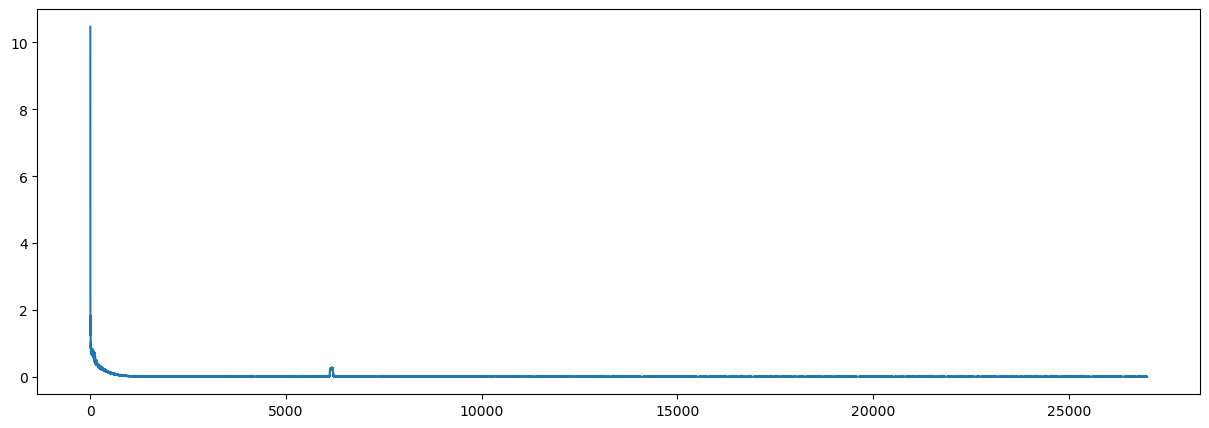

In [7]:
import torch.optim as optim

device=torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

model=RNN(batch_size, 1).to(device)

criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=0.01)
lr_scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
losses=[]
Exp_Smoothed_Loss=0
for i in range(50):
    for x, y in dl:
        # 将x计算预测值
        y_pred=model(x.float().T.unsqueeze(-1).to(device))
        # 计算损失
        loss=criterion(y_pred, y.float().unsqueeze(1).to(device))
        losses.append(loss.item())
        if i==0:
            Exp_Smoothed_Loss=loss.item()
        else:
            Exp_Smoothed_Loss=0.01*loss.item()+0.99*Exp_Smoothed_Loss
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lr_scheduler.step()
    if i%20==0:
        print("第%s次epoch，Smoothed Loss=%s，LR=%s" % (i, Exp_Smoothed_Loss, lr_scheduler.get_last_lr()))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)

i=np.arange(len(losses))+1
plt.plot(i,np.array(losses))
plt.show()

最后可以检查预测效果

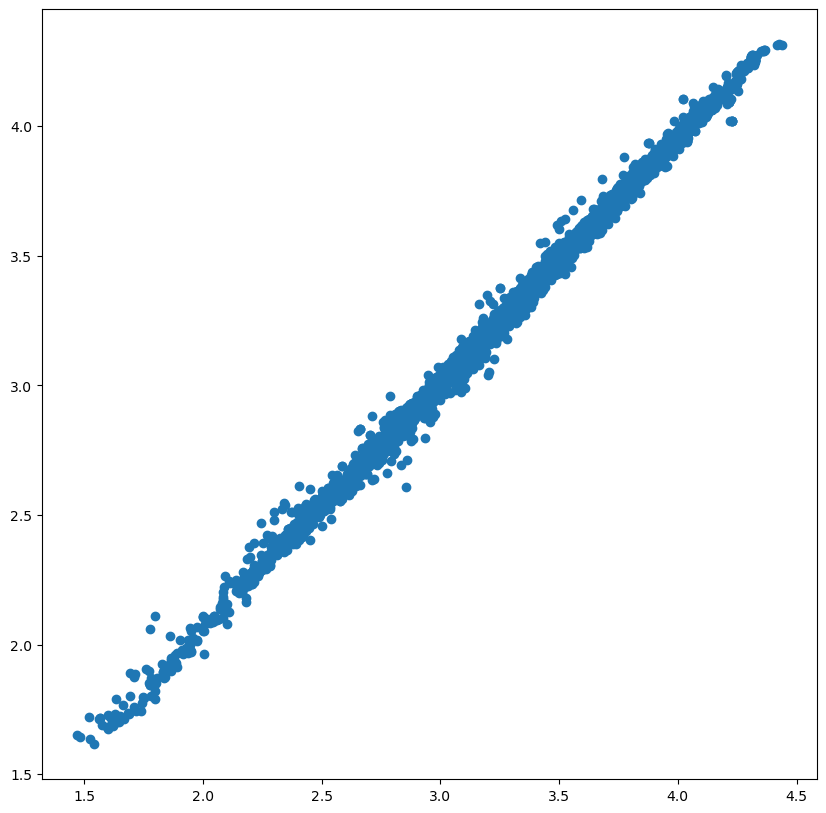

In [8]:
model.eval()

test_data = IR_data(X_test, Y_test)
tdl = DataLoader(test_data,
                 shuffle=False,
                 batch_size=batch_size,
                 drop_last=True)
pred = torch.tensor([]).to(device)
for x, y in tdl:
    p = model(x.float().T.unsqueeze(-1).to(device))
    pred = torch.cat([pred, p])

result = pd.DataFrame({
    'true_value': Y_test[:8000],
    'Predicted': pred.squeeze(1).cpu().detach().numpy()
})
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.scatter(result['true_value'], result['Predicted'])
plt.show()

In [9]:
result['residual2'] = (result['true_value'] - result['Predicted'])**2
print("RMSE = %1.5f" % np.sqrt(result['residual2'].mean()))

RMSE = 0.03644


# 长短期记忆模型（LSTM）

RNN虽然建模了不同状态之间的转移过程，然而，对于序列中的长期依赖性却并不能够很好的建模。究其原因，如果我们观察RNN对于隐藏状态的更新方式，实际上是一个类似于马尔科夫链的过程，然而对于一个马尔科夫链而言，如果时间期比较长，那么比较长的历史之前对于现在的影响要么是指数级递减的（比如一个遍历的马尔科夫链），要么是爆炸的（比如随机游走）。

而**长短期记忆模型**（**long short-term memory**，**LSTM**）使用“门”（gate）单元来建模不会随着时间消失或者爆炸的记忆，取得了非常好的效果。

如果记$h_t$为第$t$期的隐藏状态，核心难点在于如何将过去较长一段时间的历史信息进行恰当的积累。长短期记忆模型使用了一个“**遗忘门**”（**forget gate**），负责决定如何使用过去的信息，以及在使用之后“遗忘”过去的信息。

其结构如下：

![](pic/LSTM.gv.png "LSTM")

其中：

* 每一个菱形代表一个“门”，即一个可以被学习的、依赖于$h_{t-1}$和$x_t$的、取值范围为$\left(0,1\right)$的数，可以使用Sigmoid激活函数产生
* 通过遗忘门遗忘信息，外部输入门加入信息，从而产生一个更深层的“隐藏状态”，或称cell state——$c_t$，该“隐藏状态”决定了长期记忆和遗忘
* 将经过遗忘门过滤掉的信息和新加入的信息相加，得到新的$c_t$
* $c_t$也可以被一个门所关掉，即输出门

其具体公式如下：

![](pic/LSTMformula.png "LSTM公式")

LSTM的用法与RNN基本一致，区别在于nn.LSTM所返回的函数多了一个输入c_0和一个输出c_n，即cell state。

比如，我们稍加修改就可以得到LSTM版的

In [10]:
class LSTM(nn.Module):

    def __init__(self, batch_size, feature_size, hidden_size=30):
        super(LSTM, self).__init__()
        self.batch_size = batch_size  #批大小
        self.feature_size = feature_size  #特征数量
        self.hidden_size = hidden_size  #隐藏状态大小

        self.rnn = nn.LSTM(input_size=feature_size,
                           hidden_size=hidden_size,
                           num_layers=2,
                           dropout=0.5)
        self.layer2 = nn.Sequential(nn.Linear(hidden_size, 50),
                                    nn.ReLU(inplace=True), nn.LayerNorm(50),
                                    nn.Linear(50, 50), nn.ReLU(inplace=True),
                                    nn.Dropout(p=0.5), nn.Linear(50, 1))
        self.hidden = self.init_hidden()

    def init_hidden(self):
        h = torch.zeros(2, self.batch_size, self.hidden_size).to(device)
        c = torch.zeros(2, self.batch_size, self.hidden_size).to(device)
        return h, c

    def forward(self, x):
        out, h = self.rnn(x, self.hidden)
        y = self.layer2(out[-1])
        return y

第0次epoch，Smoothed Loss=0.11098627746105194，LR=[0.009000000000000001]
第20次epoch，Smoothed Loss=0.01474280677702954，LR=[0.0010941898913151245]
第40次epoch，Smoothed Loss=0.014322486665278794，LR=[0.00013302794647291155]


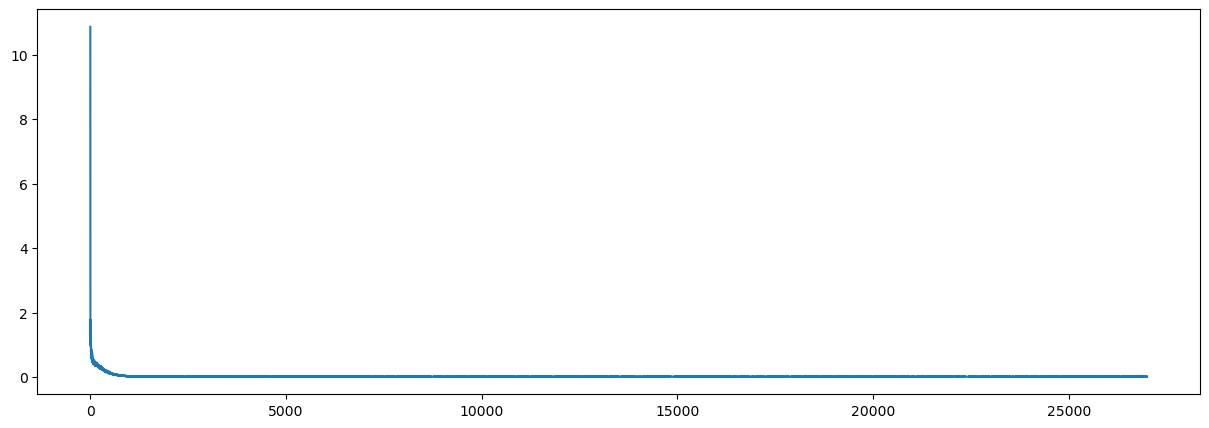

In [11]:
model = LSTM(batch_size, 1).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
losses = []
Exp_Smoothed_Loss = 0
for i in range(50):
    for x, y in dl:
        # 将x计算预测值
        y_pred = model(x.float().T.unsqueeze(-1).to(device))
        # 计算损失
        loss = criterion(y_pred, y.float().unsqueeze(1).to(device))
        losses.append(loss.item())
        if i == 0:
            Exp_Smoothed_Loss = loss.item()
        else:
            Exp_Smoothed_Loss = 0.01 * loss.item() + 0.99 * Exp_Smoothed_Loss
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lr_scheduler.step()
    if i % 20 == 0:
        print("第%s次epoch，Smoothed Loss=%s，LR=%s" %
              (i, Exp_Smoothed_Loss, lr_scheduler.get_last_lr()))

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15.0, 5.0)

i = np.arange(len(losses)) + 1
plt.plot(i, np.array(losses))
plt.show()

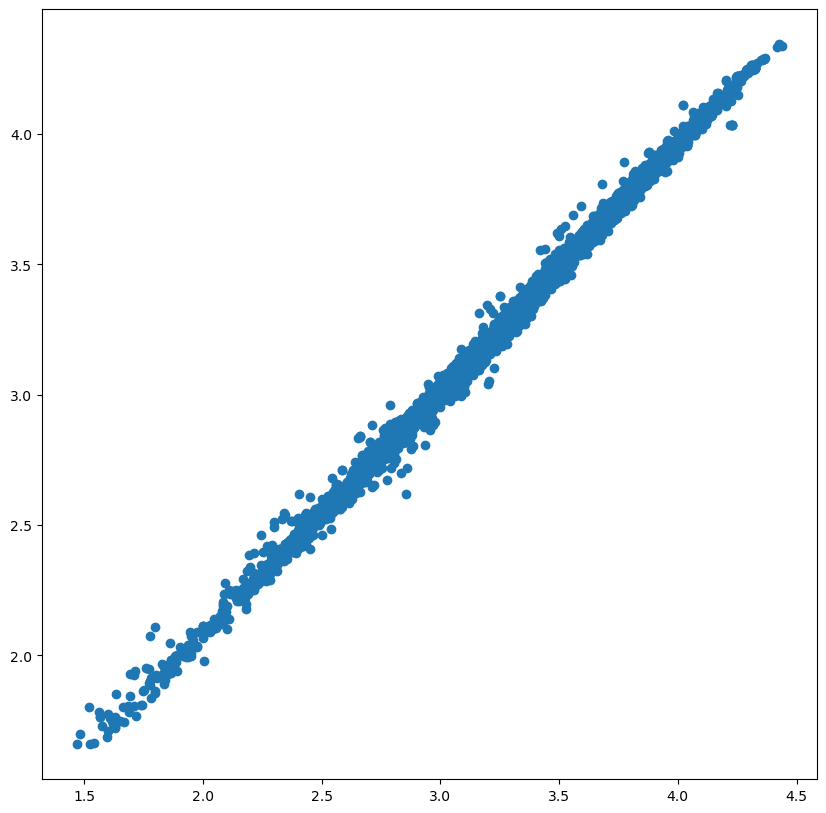

In [12]:
model.eval()

test_data = IR_data(X_test, Y_test)
tdl = DataLoader(test_data,
                 shuffle=False,
                 batch_size=batch_size,
                 drop_last=True)
pred = torch.tensor([]).to(device)
for x, y in tdl:
    p = model(x.float().T.unsqueeze(-1).to(device))
    pred = torch.cat([pred, p])

result = pd.DataFrame({
    'true_value': Y_test[:8000],
    'Predicted': pred.squeeze(1).cpu().detach().numpy()
})
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.scatter(result['true_value'], result['Predicted'])
plt.show()

In [13]:
result['residual2'] = (result['true_value'] - result['Predicted'])**2
print("RMSE = %1.5f" % np.sqrt(result['residual2'].mean()))

RMSE = 0.03665


当然，同样，以上时间序列是一个比较简单的时间序列，也没有经过特别多的调参等优化，如果感兴趣可以尝试换其他的时间序列进行尝试和调优。